# Exercise 12

SU(2) Finite size scaling of susceptibility and binder cumulant of the polyakov loop at finite temperature.

A c++ code to simulate this theory is available in the folder 'code', and the data from which these plots are made are in 'code/results'

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,10)

In [2]:
def av(dat):
    return np.average(dat)

def err(dat):
    return np.sqrt(np.var(dat)/dat.size)

In [3]:
# Read raw data: array of [Polyakov Loop, Energy = 6*vol*plaq] measurements for each L
# Simulations done at fixed (close to critical) beta:
beta_0 = 2.295
T = 4
Lvals = [8, 12, 16, 20]
dat = {}
for L in Lvals:
    vol = T * np.power(L, 3)
    dat[L] = np.array([1, -6*vol]) * np.loadtxt("code/results/T4_L%d_beta%.3f.txt" % (L, beta_0))

In [4]:
# polyakov susceptibility
# return <P^2> - <P>^2
def suscept(pol):
    return av(np.power(pol, 2)) - np.power(av(pol), 2)

# 4th order binder cumulant of polyakov loop
# return <(P-<P>)^4> / (<(P-<P>)^2>)^2 = <s^2>/<s>^2, where s=(P-<P>)^2
def binder_4(pol):
    pol_av = av(pol)
    s = np.power(pol - pol_av, 2)
    return av(np.power(s, 2))/np.power(av(s), 2)

# same thing in terms of expectation values of powers of p,
# pn == <p^n>, e.g. p3 == <p^3>
def suscept_expect(p1, p2):
    return p2 - p1*p1

def binder_4_expect(p1, p2, p3, p4):
    return ( p4 - 4*p3*p1 + 6*p2*p1*p1 - 3*np.power(p1,4) ) / np.power(p2 - p1*p1, 2)

# consistency check of above definitions
pol = np.fabs(dat[8][:,0])
p1 = av(pol)
p2 = av(np.power(pol,2))
p3 = av(np.power(pol,3))
p4 = av(np.power(pol,4))
print("suscept ", suscept(pol), suscept_expect(p1,p2))
print("binder_4 ", binder_4(pol), binder_4_expect(p1,p2,p3,p4))

suscept  0.00507223242722 0.00507223242722
binder_4  2.14678602891 2.14678602891


In [5]:
# return reweighting factor R_i for each value of E_i
# for reweighting from beta_0 to beta
def R_factor(beta, beta_0, E):
    E_shift = av(E)
    return np.exp(-(beta-beta_0)*(E-E_shift))

# return observable O reweighted with reweighting factor R
def O_rw(O, R):
    return av(O * R) / av(R)

# return bootstrap error on reweighted (suscept, binder_4)
def RW_err(dat, beta, beta_0, n_boot=100):
    resampled_rwSus = []
    resampled_rwB4 = []
    for i_boot in range(n_boot):
        # make resampled set of data by choosing N points with replacement
        new_indices = np.random.choice(np.arange(dat[:,0].size), size=dat[:,0].size, replace=True)
        resampled_E = dat[new_indices,1]
        resampled_P = dat[new_indices,0]
        resampled_R = R_factor(beta, beta_0, resampled_E)
        # Construct reweighted obs on this set of data
        rw_P1 = O_rw(resampled_P, resampled_R)
        rw_P2 = O_rw(np.power(resampled_P, 2), resampled_R)
        rw_P3 = O_rw(np.power(resampled_P, 3), resampled_R)
        rw_P4 = O_rw(np.power(resampled_P, 4), resampled_R)
        # add to set of reweighted measurements
        resampled_rwSus.append(suscept_expect(rw_P1, rw_P2))
        resampled_rwB4.append(binder_4_expect(rw_P1, rw_P2, rw_P3, rw_P4))
    # return variance of the set of measurements
    errSus = np.sqrt(np.var(resampled_rwSus))
    errB4 = np.sqrt(np.var(resampled_rwB4))
    return (errSus, errB4)

# returns reweighted (suscept, binder_4)
def RW_av(dat, beta, beta_0):
    # calculate reweighting factors
    E = dat[:,1]
    R = R_factor(beta, beta_0, E)
    #print(beta-beta_0, av(E), av(R))
    # calculate reweighted observables
    P = dat[:,0]
    rw_P1 = O_rw(P, R)
    rw_P2 = O_rw(np.power(P,2), R)
    rw_P3 = O_rw(np.power(P,3), R)
    rw_P4 = O_rw(np.power(P,4), R)
    return (suscept_expect(rw_P1, rw_P2), binder_4_expect(rw_P1, rw_P2, rw_P3, rw_P4))

In [6]:
reweighted_Sus = {}
reweighted_B4 = {}
for L in Lvals:
    V = L*L
    reweighted_Sus[L] = []
    reweighted_B4[L] = []
    for beta in np.arange(2.28, 2.40, 0.001):
        (avSus, avB4) = RW_av(dat[L], beta, beta_0)
        (errSus, errB4) = RW_err(dat[L], beta, beta_0)
        reweighted_Sus[L].append([beta, avSus, errSus])
        reweighted_B4[L].append([beta, avB4, errB4])
    reweighted_Sus[L] = np.array(reweighted_Sus[L])
    reweighted_B4[L] = np.array(reweighted_B4[L])


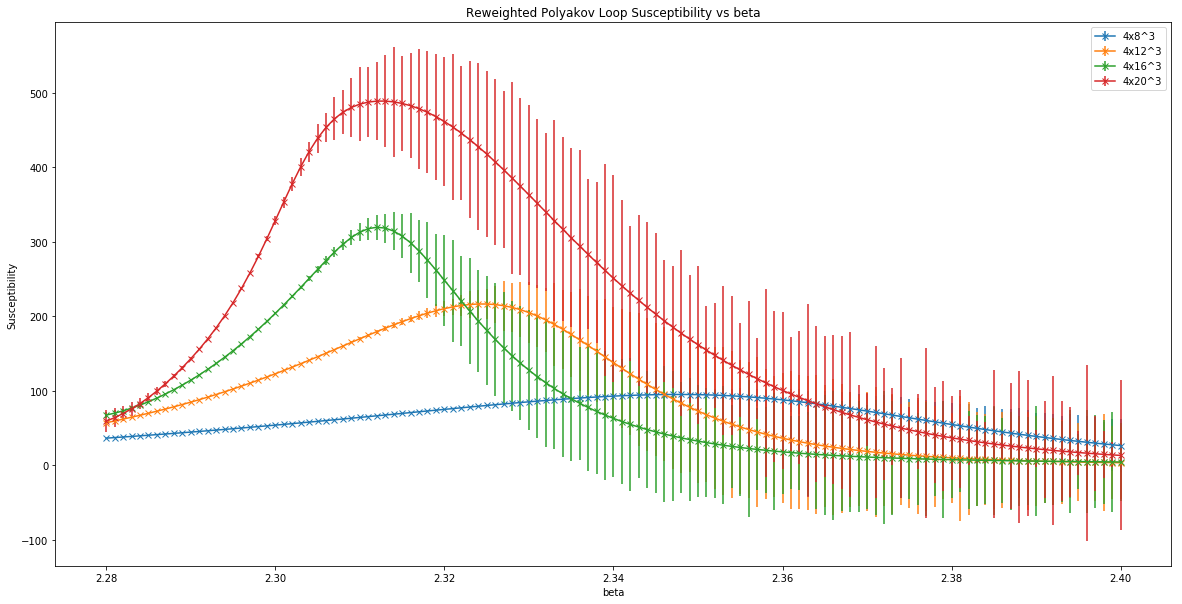

In [7]:
plt.figure()
for L in Lvals:
    vol = 4*L**3
    plt.errorbar(reweighted_Sus[L][:,0], reweighted_Sus[L][:,1]*vol, yerr=reweighted_Sus[L][:,2]*vol, marker="x", label="4x%d^3"%(L))
plt.ylabel('Susceptibility')
plt.xlabel('beta')
plt.legend()
plt.title('Reweighted Polyakov Loop Susceptibility vs beta')
plt.show()

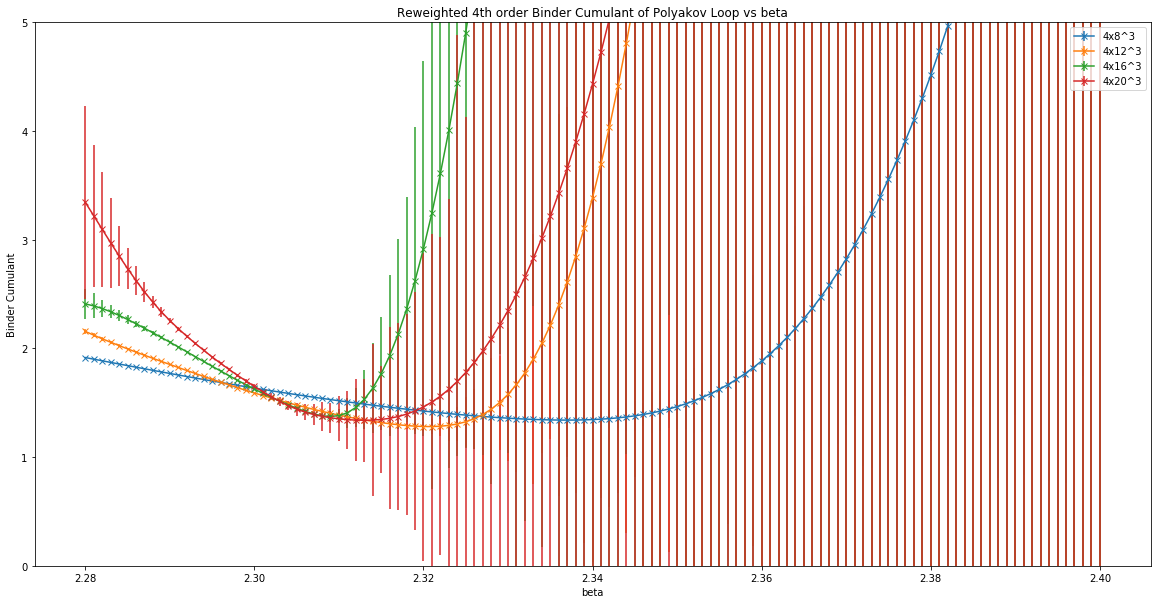

In [8]:
plt.figure()
for L in Lvals:
    plt.errorbar(reweighted_B4[L][:,0], reweighted_B4[L][:,1], yerr=reweighted_B4[L][:,2], marker="x", label="4x%d^3"%(L))
plt.ylabel('Binder Cumulant')
plt.xlabel('beta')
plt.legend()
plt.ylim([0,5])
plt.title('Reweighted 4th order Binder Cumulant of Polyakov Loop vs beta')
plt.show()

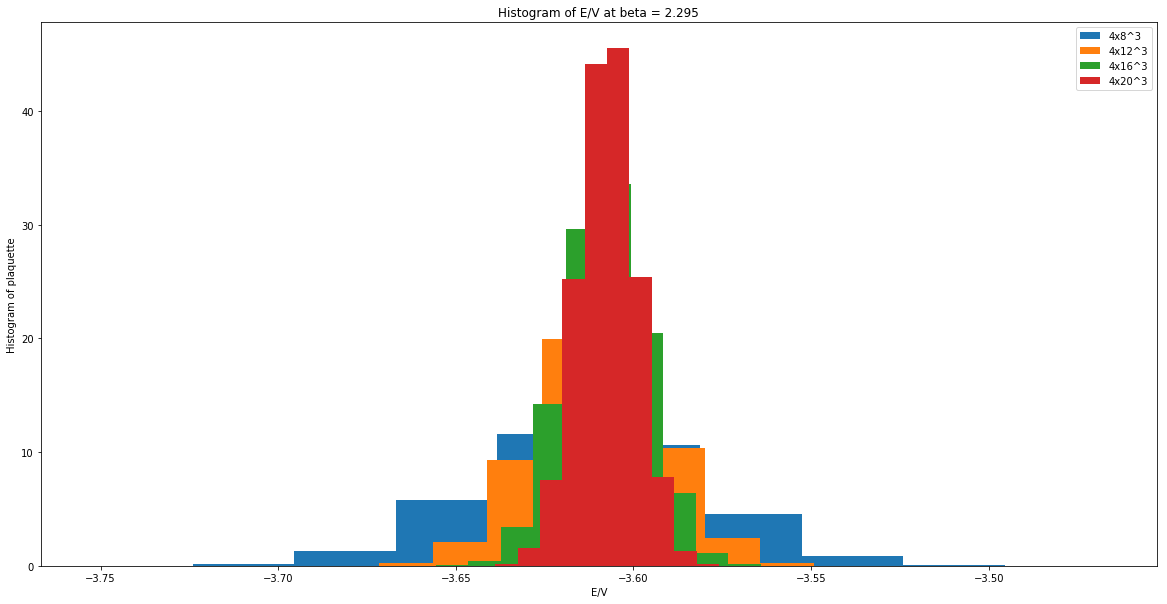

In [9]:
plt.figure()
for L in Lvals:
    plt.hist(dat[L][:,1]/(4*L*L*L), label="4x%d^3"%(L), normed=True)
plt.title('Histogram of E/V at beta = 2.295')
plt.xlabel('E/V')
plt.legend()
plt.ylabel('Histogram of plaquette')
plt.show()

Fitted beta_c:  2.30647348539


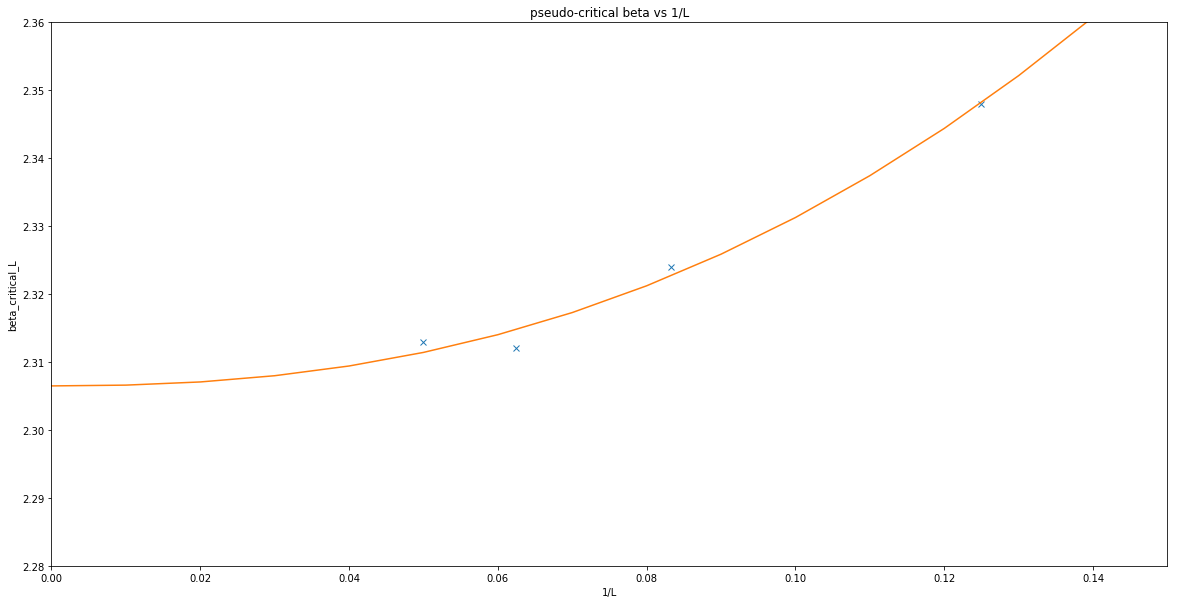

In [10]:
from scipy.optimize import curve_fit

def beta_crit_L(invL, beta_c, t_tilde, nu=0.6304):
    return beta_c + t_tilde * np.power(invL, 1.0/nu)

beta_crit=[]
for L in Lvals:
    beta_crit.append([1/L, reweighted_Sus[L][np.argmax(reweighted_Sus[L][:,1])][0]])
beta_crit = np.array(beta_crit)

popt, pcov = curve_fit(beta_crit_L, beta_crit[:,0], beta_crit[:,1])
beta_c = popt[0]
print("Fitted beta_c: ", beta_c)

plt.figure()
plt.plot(beta_crit[:,0], beta_crit[:,1], marker="x", linestyle="")    
plt.plot(np.arange(0,0.15,0.01), beta_crit_L(np.arange(0,0.15,0.01), *popt))
plt.ylabel('beta_critical_L')
plt.xlabel('1/L')
plt.xlim([0,0.15])
plt.ylim([2.28,2.36])
plt.title('pseudo-critical beta vs 1/L')
plt.show()

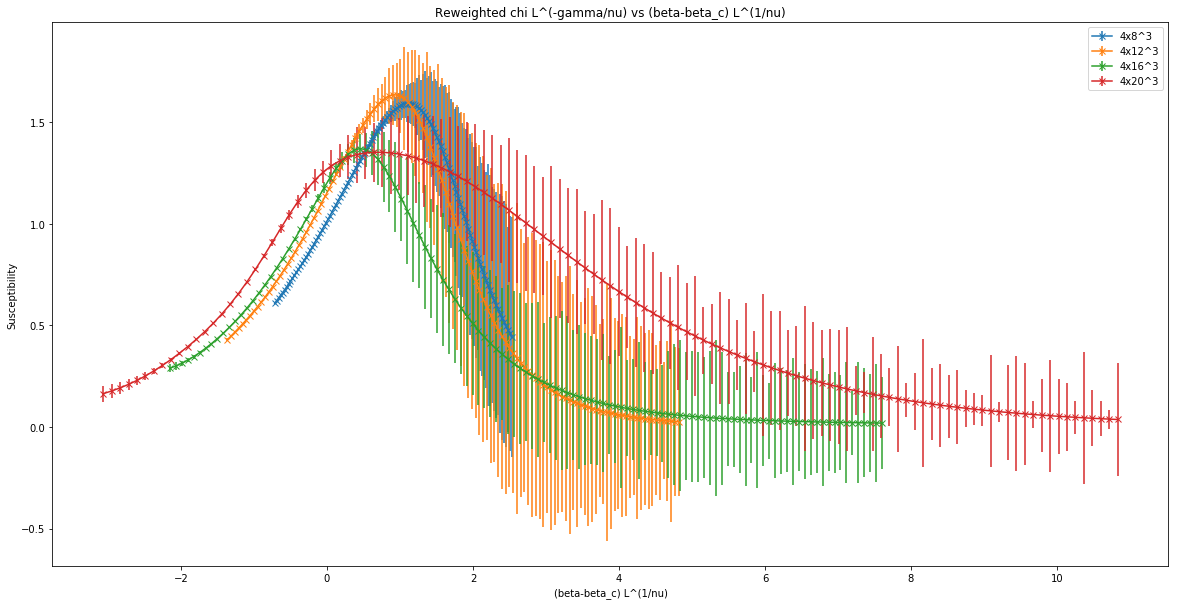

In [11]:
# assume critical exponents from 3d ising model
nu=0.6304
gamma=1.2396

plt.figure()
for L in Lvals:
    vol = 4*L**3
    plt.errorbar((reweighted_Sus[L][:,0]-beta_c)*np.power(L,1/nu), reweighted_Sus[L][:,1]*vol*np.power(L,-gamma/nu), yerr=reweighted_Sus[L][:,2]*vol*np.power(L,-gamma/nu), marker="x", label="4x%d^3"%(L))
plt.ylabel('Susceptibility')
plt.xlabel('(beta-beta_c) L^(1/nu)')
plt.legend()
plt.title('Reweighted chi L^(-gamma/nu) vs (beta-beta_c) L^(1/nu)')
plt.show()

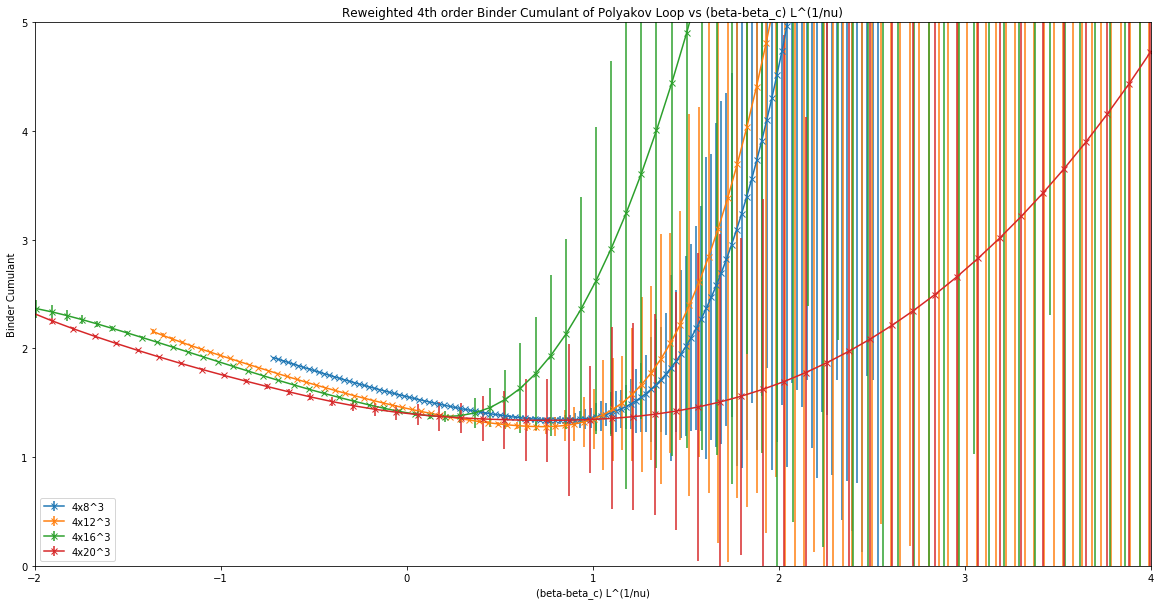

In [12]:
plt.figure()
for L in Lvals:
    plt.errorbar((reweighted_B4[L][:,0]-beta_c)*np.power(L,1/nu), reweighted_B4[L][:,1], yerr=reweighted_B4[L][:,2], marker="x", label="4x%d^3"%(L))
plt.ylabel('Binder Cumulant')
plt.xlabel('(beta-beta_c) L^(1/nu)')
plt.legend()
plt.ylim([0,5])
plt.xlim([-2,4])
plt.title('Reweighted 4th order Binder Cumulant of Polyakov Loop vs (beta-beta_c) L^(1/nu)')
plt.show()